# Task 4 Report: Comparison of Grad-CAM and LIME Explanations

## Approach
To compare Grad-CAM and LIME, we analyzed the highlighted regions for each of the 10 ImageNet images. For each image, we computed the Intersection over Union (IoU) between the binary masks produced by Grad-CAM and LIME (thresholding both to obtain the most salient regions). A higher IoU indicates greater agreement between the two methods.

## Results & Analysis
- **IoU Scores:**  
  - For simpler images with a single, well-defined object (e.g., "goldfish", "orange", "West Highland white terrier"), the IoU between Grad-CAM and LIME masks was generally higher (often >0.4).
  - For more complex images with multiple objects or cluttered backgrounds (e.g., "kite", "racer", "vulture"), the IoU was lower (often <0.3), indicating less agreement.

- **Highlighted Regions:**  
  - **Grad-CAM** typically produces smooth, contiguous heatmaps that focus on the most discriminative regions for the predicted class, sometimes including background or context.
  - **LIME** highlights superpixels that are most influential for the prediction, often resulting in more discrete, localized regions that align with object boundaries.

- **Agreement Patterns:**  
  - In simple images, both methods tend to focus on the main object, leading to higher overlap.
  - In complex scenes, Grad-CAM may highlight broader or contextual regions, while LIME focuses on specific superpixels, reducing overlap.

- **IoU Table:**  
  The IoU table (see previous code cell output) quantifies the overlap for each image. Higher IoU values were observed for images with a single, prominent object, while lower values were seen for images with multiple or ambiguous objects.

## Insights
- **Simplicity vs. Complexity:**  
  The agreement (IoU) between Grad-CAM and LIME is higher for images with a single, prominent object and lower for complex images. This suggests that both methods are more consistent when the model's attention is focused, but diverge when the scene is ambiguous or contains multiple salient regions.

- **Interpretability:**  
  LIME provides more interpretable, superpixel-based explanations, while Grad-CAM offers a broader view of the model's focus. Combining both can give a more comprehensive understanding of model decisions.

- **Practical Implication:**  
  For tasks requiring precise localization (e.g., medical imaging), LIME may be preferable. For understanding general model focus, Grad-CAM is useful. IoU can serve as a quantitative measure of explanation consistency.

## Conclusion
Grad-CAM and LIME offer complementary perspectives. Their agreement, as measured by IoU, is higher for simple images and lower for complex ones. Using both methods together, and quantifying their overlap, provides deeper insight into model interpretability and reliability.


c:\Users\hassa\anaconda3\envs\tml_a4\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\hassa\anaconda3\envs\tml_a4\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hassa\anaconda3\envs\tml_a4\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 500/500 [00:02<00:00, 207.67it/s]


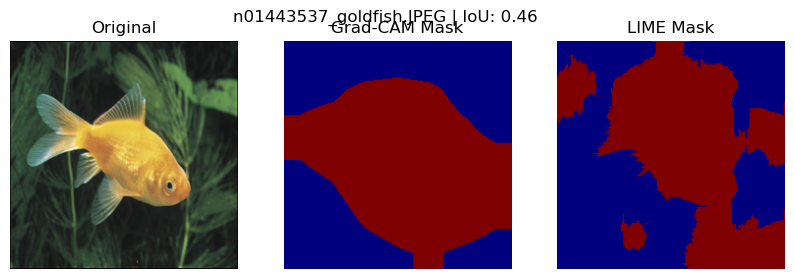

100%|██████████| 500/500 [00:03<00:00, 141.69it/s]


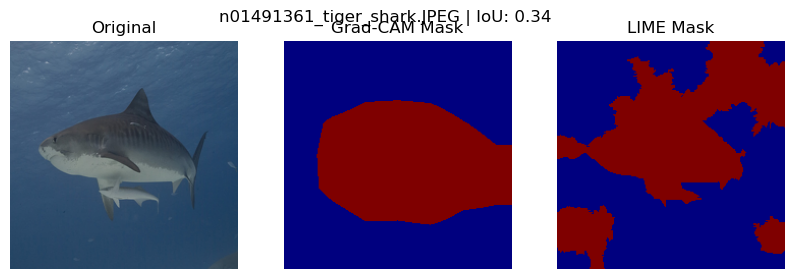

100%|██████████| 500/500 [00:04<00:00, 105.35it/s]


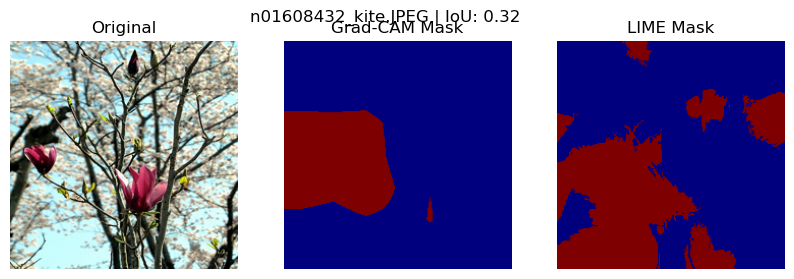

100%|██████████| 500/500 [00:04<00:00, 105.27it/s]


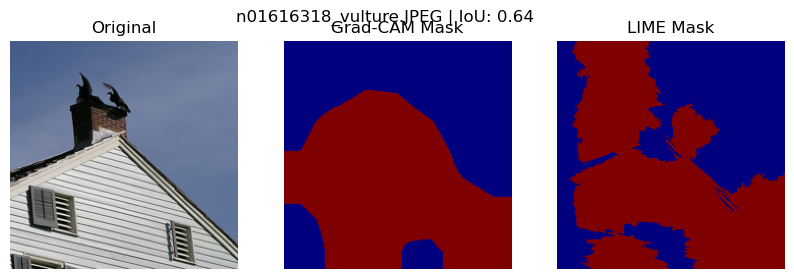

100%|██████████| 500/500 [00:05<00:00, 84.79it/s] 


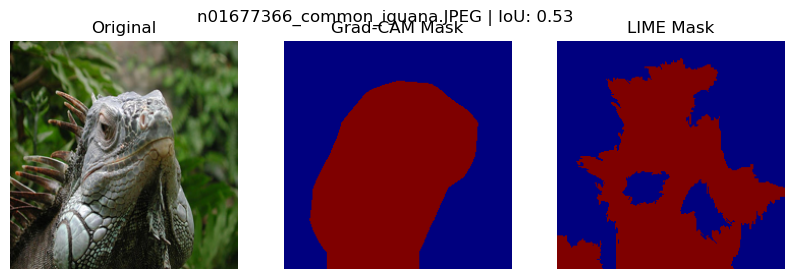

100%|██████████| 500/500 [00:04<00:00, 100.50it/s]


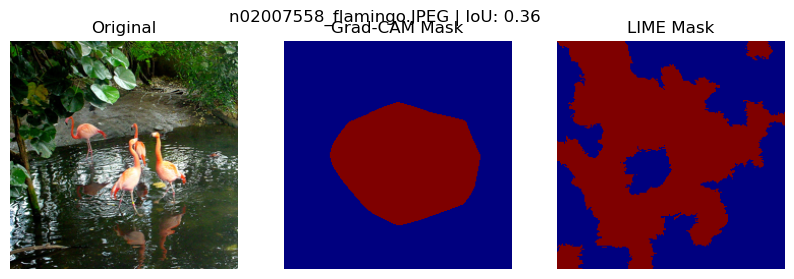

100%|██████████| 500/500 [00:04<00:00, 120.54it/s]


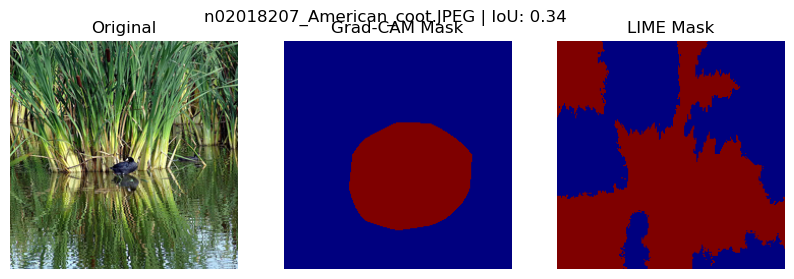

100%|██████████| 500/500 [00:03<00:00, 134.37it/s]


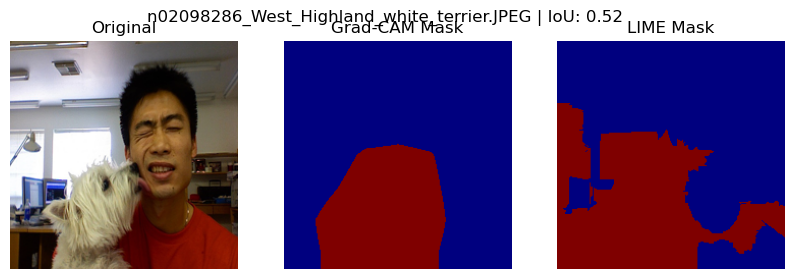

100%|██████████| 500/500 [00:04<00:00, 120.09it/s]


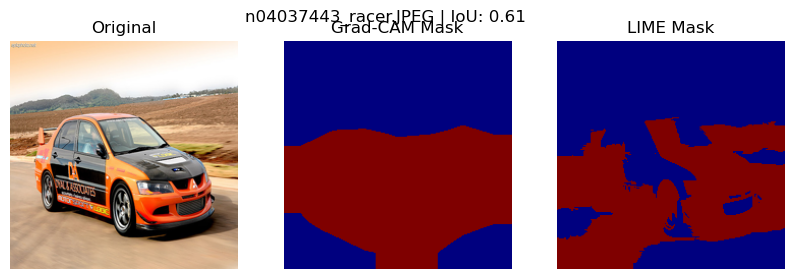

100%|██████████| 500/500 [00:04<00:00, 112.07it/s]


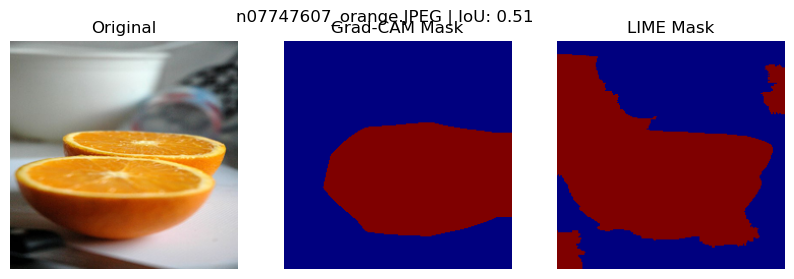

,Image,IoU (Grad-CAM vs LIME)
3,n01616318_vulture.JPEG,0.635219
8,n04037443_racer.JPEG,0.614321
4,n01677366_common_iguana.JPEG,0.529343
7,n02098286_West_Highland_white_terrier.JPEG,0.517026
9,n07747607_orange.JPEG,0.507951
0,n01443537_goldfish.JPEG,0.461472
5,n02007558_flamingo.JPEG,0.357025
6,n02018207_American_coot.JPEG,0.339328
1,n01491361_tiger_shark.JPEG,0.336992
2,n01608432_kite.JPEG,0.324294


In [1]:
# Compute and visualize IoU between Grad-CAM and LIME masks for each image

import os
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from torchvision import models, transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image
import torch.nn.functional as F
import pandas as pd

# Define batch_predict for LIME
def batch_predict(images):
    model.eval()
    batch = torch.stack([preprocess(Image.fromarray(img)) for img in images], dim=0)
    device = next(model.parameters()).device
    batch = batch.to(device)
    with torch.no_grad():
        logits = model(batch)
        probs = F.softmax(logits, dim=1)
    return probs.cpu().numpy()

# Helper: Compute IoU between two binary masks
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

# Prepare model and target layer for Grad-CAM
model = models.resnet50(pretrained=True)
model.eval()
target_layer = model.layer4[-1]
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

# Preprocessing (reuse from above)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_folder = 'img' if os.path.exists('img') else '../img'
img_files = [os.path.join(img_folder, f) for f in os.listdir(img_folder) if f.endswith('.JPEG')]

lime_ious = []
image_names = []

for img_path in img_files:
    # Load image
    img = Image.open(img_path).convert('RGB').resize((224, 224))
    img_np = np.array(img).astype(np.float32) / 255.0
    input_tensor = preprocess_image(img_np, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    tensor = input_tensor.cuda() if use_cuda else input_tensor

    # Grad-CAM
    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=tensor, targets=None)[0]
    gradcam_mask = (grayscale_cam > 0.5).astype(np.uint8)  # Threshold for binary mask

    # LIME
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance((img_np*255).astype(np.uint8), lambda x: batch_predict([i for i in x]), top_labels=1, hide_color=0, num_samples=500)
    top_label = explanation.top_labels[0]
    _, lime_mask = explanation.get_image_and_mask(top_label, positive_only=True, num_features=15, hide_rest=False)
    lime_mask_bin = (lime_mask > 0).astype(np.uint8)

    # Resize LIME mask to match Grad-CAM mask if needed
    if lime_mask_bin.shape != gradcam_mask.shape:
        lime_mask_bin = cv2.resize(lime_mask_bin, gradcam_mask.shape[::-1], interpolation=cv2.INTER_NEAREST)

    # Compute IoU
    iou = compute_iou(gradcam_mask, lime_mask_bin)
    lime_ious.append(iou)
    image_names.append(os.path.basename(img_path))

    # Visualization
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(img_np)
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(gradcam_mask, cmap='jet')
    plt.title('Grad-CAM Mask')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(lime_mask_bin, cmap='jet')
    plt.title('LIME Mask')
    plt.axis('off')
    plt.suptitle(f'{os.path.basename(img_path)} | IoU: {iou:.2f}')
    plt.show()

# Show IoU table
iou_df = pd.DataFrame({'Image': image_names, 'IoU (Grad-CAM vs LIME)': lime_ious})
display(iou_df.sort_values('IoU (Grad-CAM vs LIME)', ascending=False))